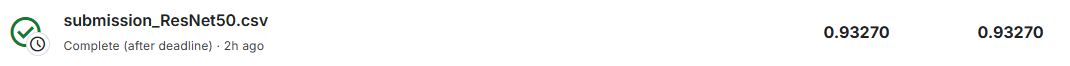

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from shutil import copyfile

# 경로 설정
csv_path = './data/CIFAR-10/trainLabels.csv'
image_dir = './data/CIFAR-10/train'  # 1.png ~ 50000.png
output_dir = './data/CIFAR-10/CIFAR-10_organized'  # 최종 저장 폴더

# CSV 불러오기
df = pd.read_csv(csv_path)

# 클래스 목록 확인
class_names = df['label'].unique()

# train/val 상위 폴더 생성
for split in ['train', 'val']:
    for class_name in class_names:
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# 클래스별로 이미지 분할 및 복사
for class_name in class_names:
    ids = df[df['label'] == class_name]['id'].values
    ids = [f"{i}.png" for i in ids]

    # train/val split
    train_ids, val_ids = train_test_split(ids, test_size=0.2, random_state=42)

    # 복사 함수
    def copy_images(file_list, split):
        for filename in file_list:
            src = os.path.join(image_dir, filename)
            dst = os.path.join(output_dir, split, class_name, filename)
            copyfile(src, dst)

    copy_images(train_ids, 'train')
    copy_images(val_ids, 'val')


In [4]:
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# 입력데이터 처리
train_dir = './data/CIFAR-10/CIFAR-10_organized/train'
val_dir = './data/CIFAR-10/CIFAR-10_organized/val'

# Parameter 설정
IMAGE_SIZE = 224
BATCH_SIZE = 64
LEARNING_RATE = 1e-5

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['truck', 'ship', 'horse', 'frog', 'dog', 'deer', 
             'cat', 'bird', 'automobile', 'airplane'],
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    classes=['truck', 'ship', 'horse', 'frog', 'dog', 'deer', 
             'cat', 'bird', 'automobile', 'airplane'],
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)


Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [6]:
# ResNet50 모델 정의 (pretrained weights 사용)
resnet50_base = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# 모델에 추가적인 레이어 추가
x = resnet50_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

# 최종 모델 정의
model = Model(inputs=resnet50_base.input, outputs=output)

# model.summary()

In [ ]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 체크포인트와 얼리 스톱 설정
cp_callback = ModelCheckpoint(filepath='./CIFAR-10_ResNet50.weights.h5',
                              save_best_only=True,
                              save_weights_only=True,
                              monitor='val_accuracy',
                              verbose=1)
es_callback = EarlyStopping(monitor='val_loss',
                            patience=5,
                            restore_best_weights=True,
                            verbose=1)

# 모델 학습
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[cp_callback, es_callback],
                    verbose=1)
# Restoring model weights from the end of the best epoch: 5.
# 625/625 [==============================] - 177s 284ms/step - 
# loss: 0.0158 - accuracy: 0.9986 - val_loss: 0.2362 - val_accuracy: 0.9361
# Epoch 10: early stopping

# Epoch 5/20
# 625/625 [==============================] - 176s 281ms/step - 
# loss: 0.0766 - accuracy: 0.9858 - val_loss: 0.2232 - val_accuracy: 0.9314

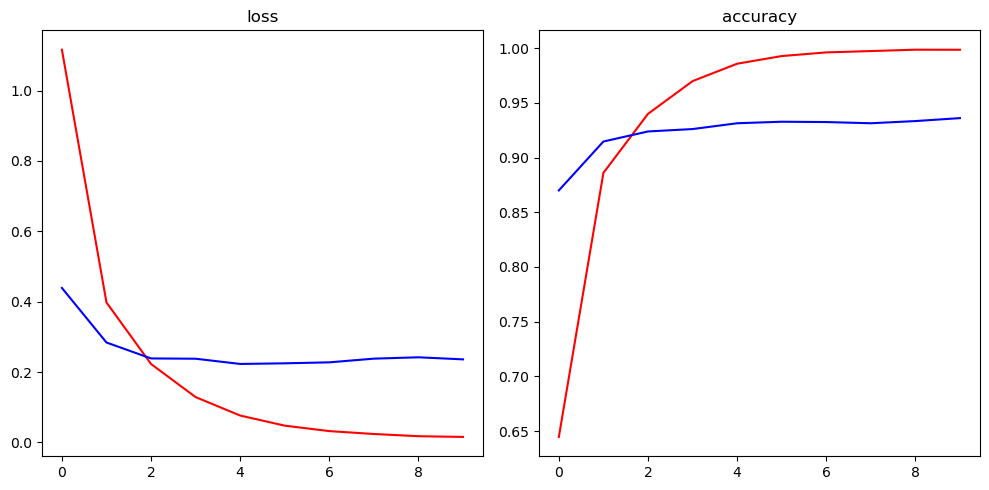

In [8]:
# 그래프
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('loss')
ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.set_title('accuracy')
ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

fig.tight_layout()

plt.show()

In [9]:
import os
import pandas as pd
from tqdm import tqdm

test_dir = './data/CIFAR-10/test'

# 파일명 리스트 -> DataFrame 생성
test_filenames = sorted(os.listdir(test_dir), key=lambda x: int(x.split('.')[0]))
test_df = pd.DataFrame({'filename': test_filenames})

# ImageDataGenerator 정의
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 300000 validated image filenames.


In [15]:
# 예측
predictions = model.predict(test_generator, verbose=1)
predicted_indices = np.argmax(predictions, axis=1)

# 클래스 인덱스 → 클래스 이름 매핑
class_names = ['truck', 'ship', 'horse', 'frog', 'dog', 'deer', 
               'cat', 'bird', 'automobile', 'airplane']
predicted_labels = [class_names[i] for i in predicted_indices]


Found 300000 validated image filenames.
4688/4688 [==============================] - 224s 48ms/step


In [ ]:
submission = pd.DataFrame({
    'id': [int(name.split('.')[0]) for name in test_filenames],
    'label': predicted_labels
})

submission.sort_values('id', inplace=True)
submission.to_csv('submission_ResNet50.csv', index=False)